In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix, homogeneity_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [2]:
df = pd.read_csv('Synthetic_Movie_Lens/ratings.csv')  
print(df)
a = df['userId'].unique()
b = df['movieId'].unique()
columns =  sorted(a)
rows = sorted(b)

        Unnamed: 0  userId  movieId  rating   timestamp
0                0     496   112852     3.0  1415520462
1                1     391     1947     4.0  1030945141
2                2     387     1562     1.5  1095041022
3                3     474     2716     4.5  1053020930
4                4     483    88125     4.5  1311337237
...            ...     ...      ...     ...         ...
100831      100831     469     1219     4.0   965661925
100832      100832     599     3571     2.0  1498511343
100833      100833     414      276     3.0   961596299
100834      100834     395      168     3.0   841503984
100835      100835     288     2407     3.5  1054568795

[100836 rows x 5 columns]


In [3]:
R = pd.DataFrame(np.nan, index=rows, columns=columns)
for index, row in df.iterrows():
    R[(int(row['userId']))][int(row['movieId'])] = row['rating']
# from scipy.sparse import csr_matrix
# # pivot ratings into movie features
# df_movie_features = df.pivot(
#     index='movieId',
#     columns='userId',
#     values='rating'
# ).fillna(0)
# # convert dataframe of movie features to scipy sparse matrix
# R = csr_matrix(df_movie_features.values)

In [4]:
sparsity = (len(rows)*len(columns) - R.isna().sum().sum())/(len(rows)*len(columns))
print("Sparsity: %0.10f " % (sparsity))

Sparsity: 0.0169996831 


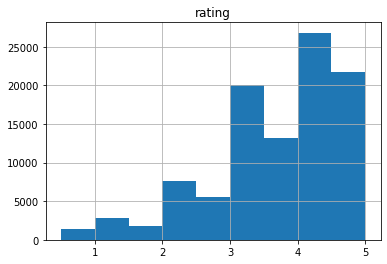

In [6]:
hist = df.hist(column= 'rating', bins=9)

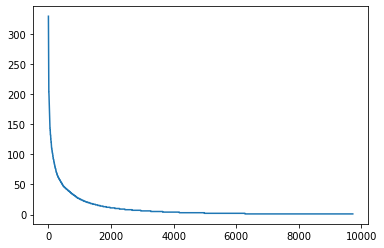

In [7]:
count = df['movieId'].value_counts()
plt.plot(count.values)

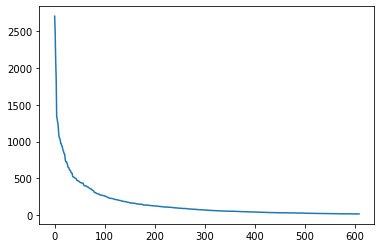

In [8]:
count = df['userId'].value_counts()
plt.plot(count.values)

(array([6.337e+03, 2.444e+03, 7.020e+02, 1.280e+02, 6.800e+01, 3.100e+01,
        7.000e+00, 4.000e+00, 3.000e+00]),
 array([0.    , 0.5625, 1.125 , 1.6875, 2.25  , 2.8125, 3.375 , 3.9375,
        4.5   , 5.0625]),
 <BarContainer object of 9 artists>)

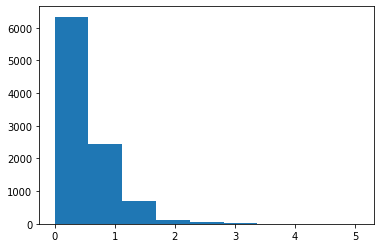

In [9]:
R.var(axis=1)
R_array = np.array(R)
R_var = np.nanvar(R_array, axis=1)
plt.hist(R_var, bins = 9)

In [10]:
from surprise import KNNBasic
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse

In [120]:
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
algorithms = [SVD(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic()]
benchmark = []
print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f699559fca0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f699559fd00>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f699559fc70>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x7f69983daac0>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x7f69983d0a00>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f699559fca0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f699559fca0> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f699559fd00>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f699559fd00> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f699559fc70>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f699559fc70> 


Starting:  

In [122]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.881822,2.158573,0.173700
KNNBaseline,0.885318,0.131510,1.432006
NMF,0.934596,2.811319,0.107659
KNNBasic,0.957600,0.038763,1.111392
NormalPredictor,1.422553,0.058646,0.200880


In [12]:
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [14]:
k = 0
results_rmse = []
results_mae = []
sim_options = {
    'name': 'pearson',
    'user_based': 'True'
    }


while 2*k < 100:
    clf = KNNBasic(k=2*k+2, sim_options = sim_options)
#     model = KNNBasic(k=2*k+2)
    result = []
    results = cross_validate(clf, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
    results_rmse.append(results['test_rmse'].mean())
    results_mae.append(results['test_mae'].mean())
    k = k+1

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1185  1.1128  1.1078  1.1029  1.111

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9701  0.9766  0.9639  0.9656  0.9734  0.9691  0.9612  0.9800  0.9772  0.9853  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9678  0.9731  0.9735  0.9836  0.9615  0.9695  0.9532  0.9543  0.9704  0.9645  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9624  0.9672  0.9667  0.9656  0.9559  0.9579  0.9638  0.9640  0.9752  0.9706  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9853  0.9724  0.9553  0.9663  0.9583  0.9562  0.9688  0.9700  0.9467  0.9709  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9593  0.9564  0.9742  0.9612  0.9786  0.9821  0.9646  0.9595  0.9629  0.9608  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9631  0.9573  0.9694  0.9774  0.9531  0.9663  0.9637  0.9698  0.9711  0.9633  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9639  0.9750  0.9566  0.9557  0.9678  0.9722  0.9625  0.9644  0.9686  0.9737  

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9613  0.9419  0.9834  0.9612  0.9622  0.9668  0.9693  0.9753  0.9745  0.9606  

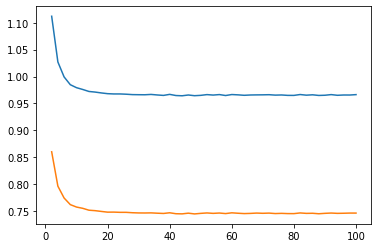

In [15]:
klist = np.linspace(2, 100, 50 )
plt.plot(klist, np.array(results_rmse))
plt.show
plt.plot(klist, np.array(results_mae))

In [16]:
import pickle
 
pickle.dump( results_rmse, open( "result_knn_rmse.pkl", "wb" ) )
pickle.dump( results_mae, open( "result_knn_mae.pkl", "wb" ) )